# ENEL 645 Final Project - Recognizing American Sign Language

Dependencies:

- Create a new conda environment
- `$ conda install -c anaconda tensorflow==2.9.1 matplotlib scikit-image scikit-learn`
- `$ conda install -c conda-forge kaggle`


In [36]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(tf.__version__)

2.9.1


## Load dataset, explore it and split it into train, validation and test sets


If you are running this tutorial locally such as in vsCode, download the dataset in the link below, unzip, and save in a new local folder called /asl-alphabet.

### Larger dataset

https://www.kaggle.com/datasets/grassknoted/asl-alphabet

If running this tutorial google colab, follow this link (https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to download an api key kaggle.json file from your kaggle acount and uncomment and the following code to download the dataset directly from kaggle.


## Code for downloading the dataset directly from Kaggle using unique api key


In [46]:
# Create new directory 
! mkdir asl_alphabet 
# Download dataset from kaggle
! KAGGLE_USERNAME=tysontrail KAGGLE_KEY=29decad2f17556a9de6abf9e5b93dc21 kaggle datasets download -d grassknoted/asl-alphabet 
# Unzip and save in newly created directory
! unzip -q asl-alphabet.zip -d asl_alphabet/ 

mkdir: asl_alphabet: File exists
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
replace asl_alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Set Datasets Using Dataset From Directory Class

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory


In [4]:
# Create class names
class_names = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "del",
    "nothing",
    "space",
]

# Paths to the downloaded dataset
train_dir = "asl_alphabet/asl_alphabet_train/asl_alphabet_train"

# Parameters of images in the dataset
IMG_SIZE = (224, 224)

BATCH_SIZE = 28

# set the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode="categorical",
)


Found 87000 files belonging to 29 classes.


2023-04-02 15:23:53.343597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plot Samples From the first batch of training data


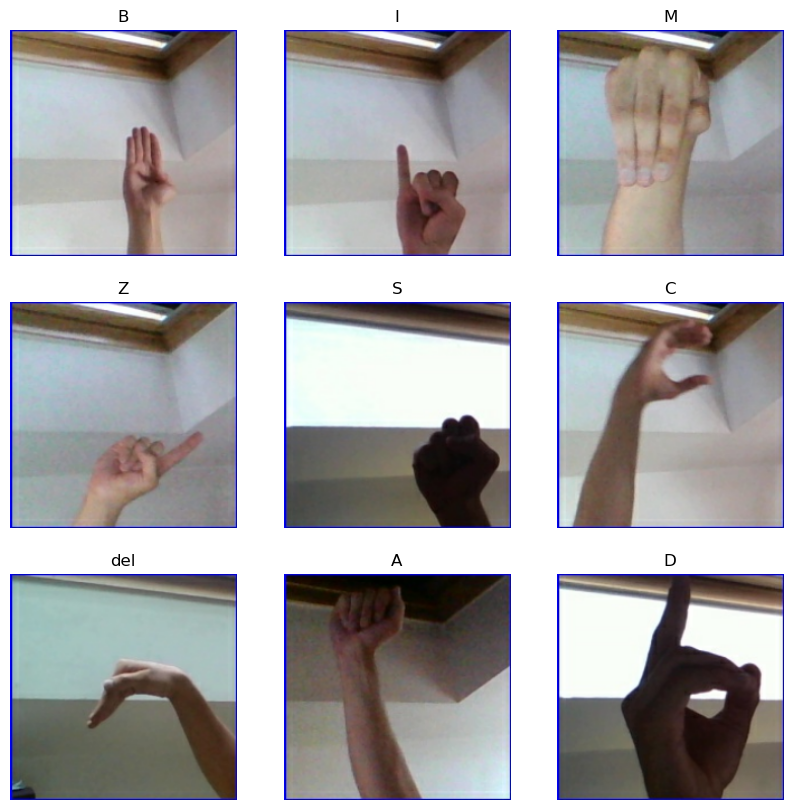

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


## Split dataset Into train and test

First Split into train and test datasets. 20% is dedicated to testing, and 80% to training.


In [6]:
training_batches = tf.data.experimental.cardinality(train_dataset)
number_of_batches_for_testing = training_batches // 5
test_dataset = train_dataset.take(number_of_batches_for_testing)
train_dataset = train_dataset.skip(number_of_batches_for_testing)

print(
    "Number of training batches: %d"
    % tf.data.experimental.cardinality(train_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)


Number of training batches: 2487
Number of test batches: 621


## Now split test into test and validation

Split the 20% of testing in half: 10% for to testing, and 10% to validation


In [7]:
number_of_batches_for_validation = number_of_batches_for_testing // 2
validation_dataset = test_dataset.take(number_of_batches_for_validation)
test_dataset = test_dataset.skip(number_of_batches_for_validation)


In [8]:
print(
    "Number of training batches: %d"
    % tf.data.experimental.cardinality(train_dataset)
)
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print(
    "Number of test batches: %d"
    % tf.data.experimental.cardinality(test_dataset)
)


Number of training batches: 2487
Number of validation batches: 310
Number of test batches: 311


## Improve Runtime

https://www.tensorflow.org/guide/data_performance


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Input pre-processing Steps

Since our model is EfficientNetB2, we use the efficientnet preprocessor


In [35]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input


# Testing the model

In [10]:
# Load the best model
model = tf.keras.models.load_model('training_classifier_asl.h5')

# Model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 29)                40861     
                                                             

In [35]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the test accuracy and loss
print("test loss: {:.2f}".format(test_loss))
print("test accuracy: {:.2f}".format(test_accuracy))

311/311 [==============================] - 304s 964ms/step - loss: 0.3069 - accuracy: 0.9295
test loss: 0.31
test accuracy: 0.93


# Plotting Model Results on Test Dataset

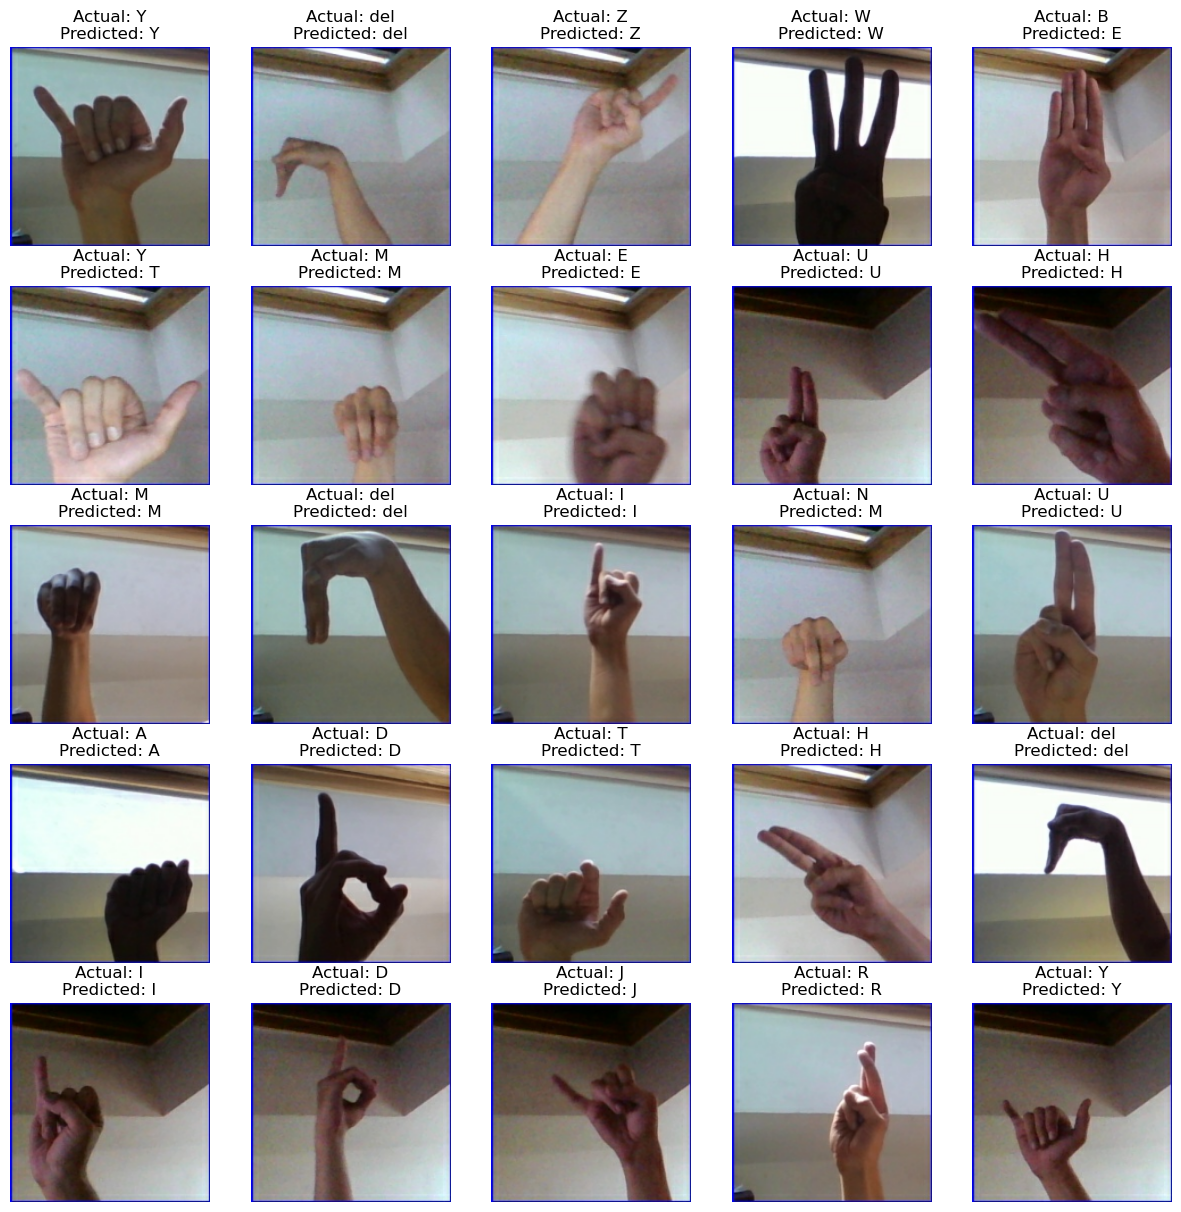

In [34]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Make predictions
predictions = model.predict_on_batch(image_batch)

# Find the index of the highest prediction for each image
max_indices = np.argmax(predictions, axis=1)

# Get the class name for each predicted index
predicted_labels = [class_names[i] for i in max_indices]

# Convert the one-hot encoded labels to a single integer label
label_batch = np.argmax(label_batch, axis=1)

# Get the class name for each true index
actual_labels = [class_names[i] for i in label_batch]

# Plot the first 25 images and their predicted and true labels
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis("off")

# Creating a Confusion Matrix

In [20]:
# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop over the test dataset
for images, labels in test_dataset:

    # Make predictions using the trained model
    predictions = model.predict(images)

    # Store the predicted labels
    predicted_labels.extend(predictions)
    
    # Store the true labels
    true_labels.extend(labels)

# Convert the lists to NumPy arrays and find the index of the highest prediction for each image
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(true_labels, axis=1)

1/1 [==============================] - 1s 936ms/step
[[296   0   0   0   3   0   0   0   0   0   0   0   2   0   0   0   0   0
    5   5   0   0   0   0   0   0   0   0   0]
 [ 10 285   0   0  21   0   0   0   2   0   4   0   1   0   0   0   0   0
    2   0   0   0   0   2   0   0   0   0   0]
 [  0   0 290   0   0   0   0   0   0   0   0   3   0   0   0   0   3   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 286   0   2   0   0   1   1   2   9   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   1   0 251   6   1   0   1   4   0   0   0   0   0   0   0   0
   19   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 297   1   0   0   0   1   4   0   0   0   0   0   0
    2   3   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 293   1   4   1   0   0   0   0   0   0   0   0
    0   1   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   6 311   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0 

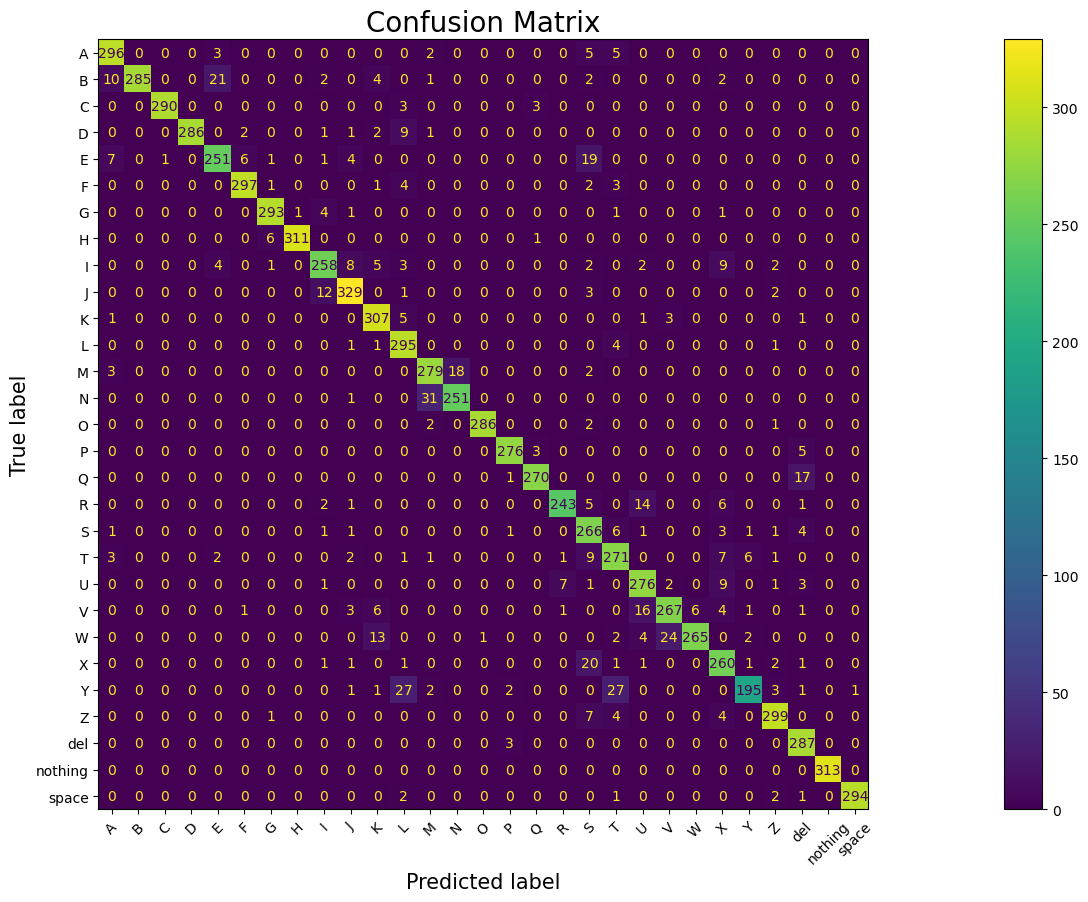

Accuracy: 0.9297197978870004


In [33]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Create figure and axes
fig, ax = plt.subplots(figsize=(35, 10))
disp.plot(ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted label', fontsize=15)
ax.set_ylabel('True label', fontsize=15)
ax.set_title('Confusion Matrix', fontsize=20)

# Slant the horizontal labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Calculate accuracy
accuracy = np.sum(np.diagonal(cm)) / np.sum(cm)
print("Accuracy:", accuracy)